In [9]:
!pip -q install xgboost


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix, roc_curve, auc


In [15]:
# Read csv files
df= pd.read_csv("/content/drive/MyDrive/DS-II/second_feature_df_22_12_2025.csv")
df.head(10)

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,GCS_max,GCS_mean,Lactate_min,Lactate_max,Lactate_mean,BUN_min,BUN_mean,...,TEMP_STD,TEMP_MIN,HR_MEAN,HR_MAX,HR_STD,RDW_max,RDW_mean,RDW_min,RDW_std,age_adj_comorbidity_score
0,3,145834,211552,6.0,4.444444,1.3,8.8,3.800000,36.0,40.500000,...,0.335085,36.200001,98.925373,168.0,28.103334,15.7,15.400000,15.0,0.273861,16.0
1,6,107064,228232,6.0,6.000000,NaN,NaN,NaN,65.0,65.500000,...,0.441010,36.000002,84.791667,100.0,5.573334,17.0,16.450000,15.9,0.777817,12.0
2,9,150750,220597,5.0,2.600000,1.9,2.7,2.380000,17.0,18.500000,...,0.822093,35.500001,87.644737,111.0,8.162849,14.3,14.000000,13.8,0.264575,12.0
3,12,112213,232669,6.0,4.842105,1.6,15.1,8.716667,28.0,35.500000,...,0.837151,35.500001,83.208333,105.0,8.518311,14.9,14.625000,14.2,0.309570,7.0
4,17,194023,277042,6.0,5.615385,0.9,0.9,0.900000,10.0,10.666667,...,0.623295,36.000002,82.400000,114.0,11.049719,12.9,12.766667,12.6,0.152753,0.0
5,21,109451,217847,6.0,6.000000,1.5,2.3,2.060000,50.0,77.666667,...,0.459382,35.388887,71.690909,125.0,17.346013,18.2,17.700000,17.4,0.435890,21.0
6,21,111970,216859,6.0,5.923077,1.6,2.7,2.150000,50.0,56.500000,...,0.654310,35.944443,77.580645,100.0,7.898015,17.7,17.200000,16.7,0.707107,20.0
7,25,129635,203487,6.0,6.000000,1.0,1.8,1.400000,34.0,46.333333,...,0.528102,35.722224,76.898305,104.0,10.540063,13.1,13.000000,12.9,0.081650,1.0
8,26,197661,244882,6.0,6.000000,NaN,NaN,NaN,28.0,29.500000,...,0.453136,36.499998,70.404255,86.0,7.859250,13.7,13.500000,13.3,0.282843,15.0
9,31,128652,254478,4.0,2.920000,1.4,1.5,1.450000,11.0,12.000000,...,0.757767,35.000000,50.948718,57.0,2.790479,15.2,14.950000,14.7,0.353553,18.0


In [17]:
import os

if os.path.exists('/content/drive'):
    print('Google Drive is mounted.')
else:
    print('Google Drive is not mounted.')

Google Drive is mounted.


In [18]:
# Find dataset size and column data types
print(df.shape)
pd.DataFrame({"column": df.columns, "dtype": df.dtypes.values})


(21178, 40)


,column,dtype
0,SUBJECT_ID,int64
1,HADM_ID,int64
2,ICUSTAY_ID,int64
3,GCS_max,float64
4,GCS_mean,float64
5,Lactate_min,float64
6,Lactate_max,float64
7,Lactate_mean,float64
8,BUN_min,float64
9,BUN_mean,float64


In [19]:
# Checking missing values
df.isnull().sum()

,0
SUBJECT_ID,0
HADM_ID,0
ICUSTAY_ID,0
GCS_max,309
GCS_mean,309
Lactate_min,9328
Lactate_max,9328
Lactate_mean,9328
BUN_min,171
BUN_mean,171


In [20]:
# Checking missing value of Target varaible
df['MORTALITY_INHOSPITAL'].isnull().sum()

np.int64(0)

In [21]:
# Print the all columns names
print(df.columns.tolist())

['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'GCS_max', 'GCS_mean', 'Lactate_min', 'Lactate_max', 'Lactate_mean', 'BUN_min', 'BUN_mean', 'AG_max', 'AG_mean', 'Bilirubin_max', 'Bilirubin_mean', 'MORTALITY_INHOSPITAL', 'AG_MEAN', 'AG_MAX', 'AG_MEDIAN', 'AG_MIN', 'AG_STD', 'SYSBP_MIN', 'SYSBP_MEAN', 'SYSBP_STD', 'DIASBP_MIN', 'DIASBP_MEAN', 'AGE', 'RR_MEAN', 'RR_STD', 'RR_MAX', 'RR_MIN', 'TEMP_STD', 'TEMP_MIN', 'HR_MEAN', 'HR_MAX', 'HR_STD', 'RDW_max', 'RDW_mean', 'RDW_min', 'RDW_std', 'age_adj_comorbidity_score']


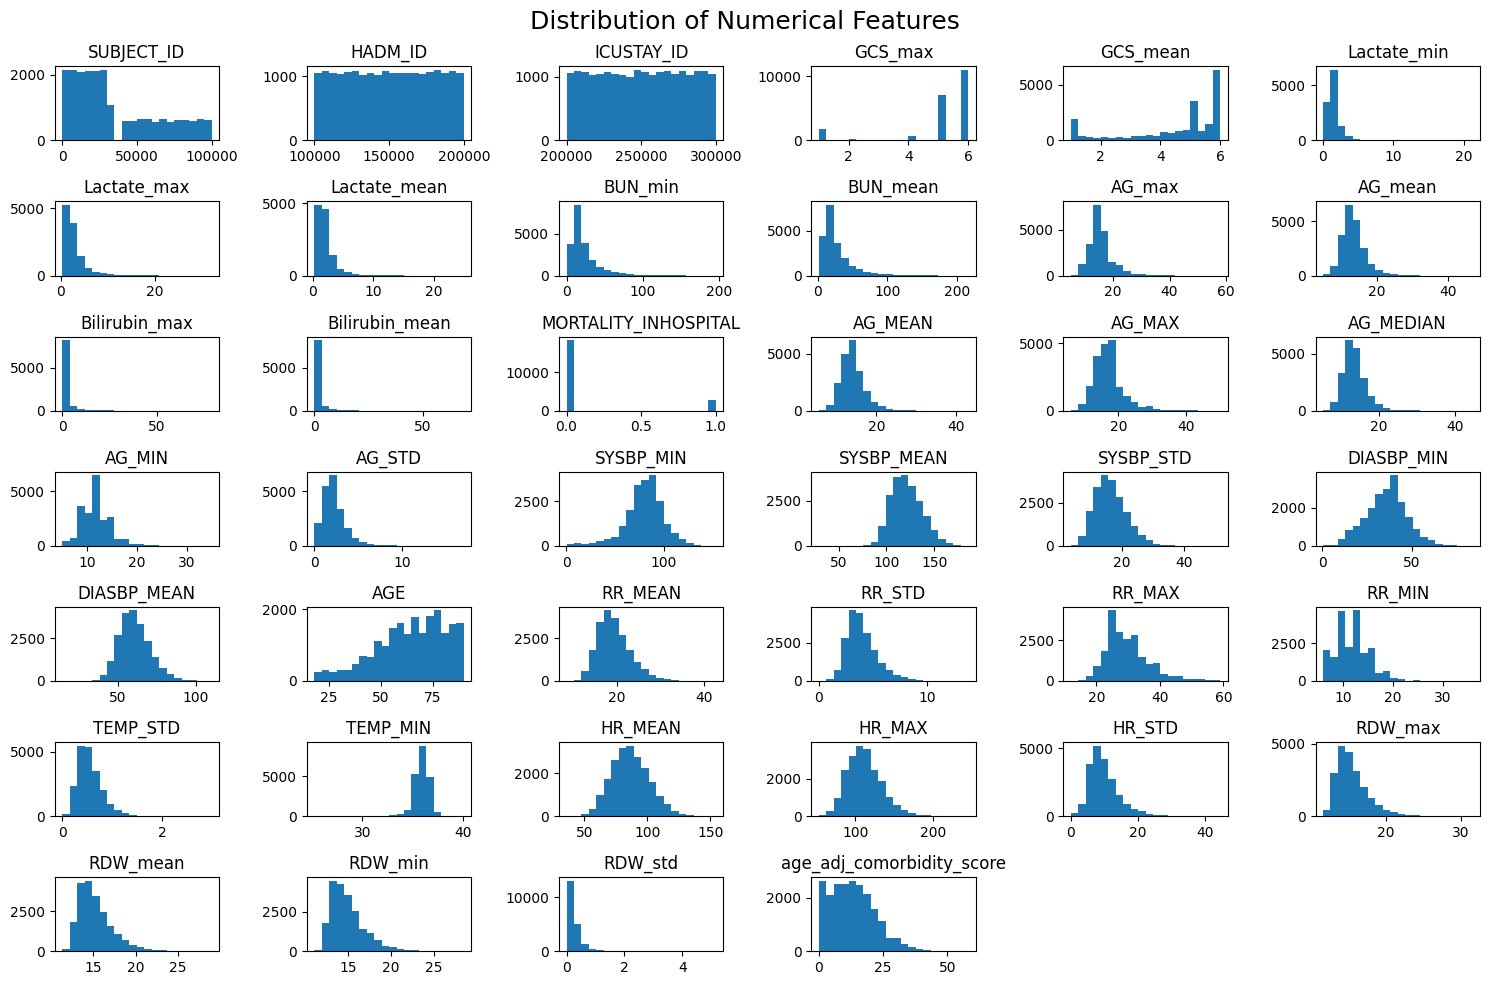

In [22]:
# Univariate Analysis
df.hist(bins=20, figsize=(15, 10), grid=False)
plt.suptitle("Distribution of Numerical Features", fontsize=18)
plt.tight_layout()
plt.show()

In [23]:
# Calculate correlation matrix
corr_matrix = df.corr()
print(corr_matrix)

                           SUBJECT_ID   HADM_ID  ICUSTAY_ID   GCS_max  \
SUBJECT_ID                   1.000000  0.017328    0.001473 -0.481498   
HADM_ID                      0.017328  1.000000   -0.002751 -0.005379   
ICUSTAY_ID                   0.001473 -0.002751    1.000000 -0.012372   
GCS_max                     -0.481498 -0.005379   -0.012372  1.000000   
GCS_mean                    -0.484551 -0.006291   -0.012566  0.837490   
Lactate_min                 -0.094316 -0.017985    0.004463  0.019481   
Lactate_max                 -0.056030 -0.004538    0.024412 -0.095327   
Lactate_mean                -0.075609 -0.009534    0.018717 -0.055528   
BUN_min                     -0.037293 -0.011020    0.005317 -0.015298   
BUN_mean                    -0.035032 -0.010307    0.004691 -0.022176   
AG_max                      -0.040374 -0.012405    0.011590 -0.060758   
AG_mean                     -0.068840 -0.014146    0.011130 -0.019658   
Bilirubin_max               -0.004472 -0.007118   -

In [24]:
# Split data
X = df.drop(['MORTALITY_INHOSPITAL','SUBJECT_ID','HADM_ID','ICUSTAY_ID'], axis=1)
y = df['MORTALITY_INHOSPITAL']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train size: {len(X_train)}")
print(f"Test size: {len(X_test)}")


# Filled the missing values with x_train median to avoid data leakage
medians = X_train.median()
X_train = X_train.fillna(medians)
X_test  = X_test.fillna(medians)


Train size: 16942
Test size: 4236


In [26]:
# Train the different model

model_lr= LogisticRegression(class_weight="balanced", max_iter=2000)
model_lr.fit(X_train, y_train)

model_dtc=DecisionTreeClassifier(max_depth=4, min_samples_leaf=50, class_weight="balanced", random_state=42)
model_dtc.fit(X_train, y_train)

model_rfc= RandomForestClassifier(n_estimators=400,random_state=42,n_jobs=-1,class_weight="balanced_subsample")
model_rfc.fit(X_train, y_train)
from lightgbm import LGBMClassifier







def calculation(model, X_test, y_test, threshold=0.5):
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)

    auroc = roc_auc_score(y_test, y_prob)
    ap = average_precision_score(y_test, y_prob)
    cf_matrix = confusion_matrix(y_test, y_pred)
    cl_report = classification_report(y_test, y_pred, digits=4)
    return auroc, ap, cf_matrix, cl_report

# Calculate metrics for all models
print("Linear Regression:")
auroc, ap, cf_matrix, cl_report = calculation(model_lr, X_test, y_test)
print(f"Area Under the Receiver Operating Characteristic curve:{auroc}, Average Precision:{ap}")
print('Confusion Matrix:')
print(cf_matrix)
print('Classification Report:')
print(cl_report)

print("DecisionTreeClassifier:")
auroc, ap, cf_matrix, cl_report = calculation(model_lr, X_test, y_test)
print(f"Area Under the Receiver Operating Characteristic curve:{auroc}, Average Precision:{ap}")
print('Confusion Matrix:')
print(cf_matrix)
print('Classification Report:')
print(cl_report)

print("Random Forest:")
auroc, ap, cf_matrix, cl_report = calculation(model_rfc, X_test, y_test)
print(f"Area Under the Receiver Operating Characteristic curve:{auroc}, Average Precision:{ap}")
print('Confusion Matrix:')
print(cf_matrix)
print('Classification Report:')
print(cl_report)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Info] Number of positive: 2202, number of negative: 14740
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6126
[LightGBM] [Info] Number of data points in the train set: 16942, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.129973 -> initscore=-1.901199
[LightGBM] [Info] Start training from score -1.901199
Linear Regression:
Area Under the Receiver Operating Characteristic curve:0.8612553642776107, Average Precision:0.5681834667674684
Confusion Matrix:
[[3015  671]
 [ 130  420]]
Classification Report:
              precision    recall  f1-score   support

           0     0.9587    0.8180    0.8827      3686
           1     0.3850    0.7636    0.5119       550

    accuracy                         0.8109      4236
   macro avg     0.6718    0.7908    0.6973      4236
weighted avg     0.8842    0.8109   

In [33]:
# XGBoost model

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

model_xgb=xgb.XGBClassifier(
        n_estimators=600,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        scale_pos_weight=scale_pos_weight,
        eval_metric="auc",
        random_state=42,
        n_jobs=-1)

model_xgb.fit(X_train, y_train)

print("XGBoost Classifier:")
auroc, ap, cf_matrix, cl_report = calculation(model_xgb, X_test, y_test)
print(f"Area Under the Receiver Operating Characteristic curve:{auroc}, Average Precision:{ap}")
print('Confusion Matrix:')
print(cf_matrix)
print('Classification Report:')
print(cl_report)

# LightGBM model
import lightgbm as lgb

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

model_lgbm = lgb.LGBMClassifier(n_estimators=600,learning_rate=0.05,
    max_depth=5,          # set -1 for "no limit"
    num_leaves=31,        # common default; tune if needed
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    scale_pos_weight=scale_pos_weight,
    objective="binary",
    random_state=42,
    n_jobs=-1
)

model_lgbm.fit(X_train, y_train)

print("LightGBM Classifier:")
auroc, ap, cf_matrix, cl_report = calculation(model_lgbm, X_test, y_test)
print(f"Area Under the Receiver Operating Characteristic curve:{auroc}, Average Precision:{ap}")
print('Confusion Matrix:')
print(cf_matrix)
print('Classification Report:')
print(cl_report)



XGBoost Classifier:
Area Under the Receiver Operating Characteristic curve:0.8775657278153208, Average Precision:0.6405461815260729
Confusion Matrix:
[[3405  281]
 [ 205  345]]
Classification Report:
              precision    recall  f1-score   support

           0     0.9432    0.9238    0.9334      3686
           1     0.5511    0.6273    0.5867       550

    accuracy                         0.8853      4236
   macro avg     0.7472    0.7755    0.7601      4236
weighted avg     0.8923    0.8853    0.8884      4236

[LightGBM] [Info] Number of positive: 2202, number of negative: 14740
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6126
[LightGBM] [Info] Number of data points in the train set: 16942, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.129973 -> initscore=-1.901199
[LightGBM] [Info] Start training f

In [35]:
# With KFold cross validation

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {"auroc": "roc_auc", "ap": "average_precision"}

def run_cv(name, model):
    res = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)

    auroc_mean = res['test_auroc'].mean()
    auroc_std  = res['test_auroc'].std()
    ap_mean    = res['test_ap'].mean()
    ap_std     = res['test_ap'].std()

    print(f"{name} (5-Fold CV)")
    print(f"AUROC: {auroc_mean:.4f} ± {auroc_std:.4f}")
    print(f"AP: {ap_mean:.4f} ± {ap_std:.4f}\n")

    return {"model": name,"auroc_mean": auroc_mean, "auroc_std": auroc_std,"ap_mean": ap_mean, "ap_std": ap_std}

# Logistic Regression
lr_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")), ("model", model_lr)])

# Decision Tree
dtc_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")), ("model", model_dtc)])

# Random Forest
rfc_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")), ("model", model_rfc)])

# XGBoost model
xgb_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")), ("model", model_xgb)])

# LightGBM model
lgbm_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")),("model", model_lgbm)])


# Collecting results
results = []

results.append(run_cv("Logistic Regression", lr_pipe))
results.append(run_cv("Decision Tree", dtc_pipe))
results.append(run_cv("Random Forest", rfc_pipe))
results.append(run_cv("XGBoost", xgb_pipe))
results.append(run_cv("LightGBM", lgbm_pipe))

print(results)

Logistic Regression (5-Fold CV)
AUROC: 0.8647 ± 0.0110
AP: 0.5502 ± 0.0312

Decision Tree (5-Fold CV)
AUROC: 0.8252 ± 0.0044
AP: 0.4770 ± 0.0162

Random Forest (5-Fold CV)
AUROC: 0.8793 ± 0.0082
AP: 0.5921 ± 0.0237

XGBoost (5-Fold CV)
AUROC: 0.8828 ± 0.0090
AP: 0.6303 ± 0.0265



/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


LightGBM (5-Fold CV)
AUROC: 0.8778 ± 0.0077
AP: 0.6214 ± 0.0236

[{'model': 'Logistic Regression', 'auroc_mean': np.float64(0.8647009652921651), 'auroc_std': np.float64(0.010965174041088013), 'ap_mean': np.float64(0.5501965949475575), 'ap_std': np.float64(0.031243357606941396)}, {'model': 'Decision Tree', 'auroc_mean': np.float64(0.8252477984018738), 'auroc_std': np.float64(0.004431317227650073), 'ap_mean': np.float64(0.4770295255267752), 'ap_std': np.float64(0.0161867051171243)}, {'model': 'Random Forest', 'auroc_mean': np.float64(0.8793337932393467), 'auroc_std': np.float64(0.008219629382089326), 'ap_mean': np.float64(0.5920751430720526), 'ap_std': np.float64(0.023667455831076472)}, {'model': 'XGBoost', 'auroc_mean': np.float64(0.8827864580929614), 'auroc_std': np.float64(0.008987703906850912), 'ap_mean': np.float64(0.6302629956526119), 'ap_std': np.float64(0.02653046064104594)}, {'model': 'LightGBM', 'auroc_mean': np.float64(0.877846049556289), 'auroc_std': np.float64(0.007690463426

In [36]:
# Create dataframe of result
results_df = pd.DataFrame(results)
results_df

,model,auroc_mean,auroc_std,ap_mean,ap_std
0,Logistic Regression,0.864701,0.010965,0.550197,0.031243
1,Decision Tree,0.825248,0.004431,0.477030,0.016187
2,Random Forest,0.879334,0.008220,0.592075,0.023667
3,XGBoost,0.882786,0.008988,0.630263,0.026530
4,LightGBM,0.877846,0.007690,0.621360,0.023622


In [38]:
# Finding the best model
best_model = results_df.sort_values(by=["ap_mean", "auroc_mean"],ascending=False).iloc[0]

print("Selected model:", best_model["model"])

Selected model: XGBoost
